# Bruna v.2


**sections**:
- set-up & settings
- the model
- the dataset
- the loss
- adversarial (for task2)
- running the code

### SetUp and Settings

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install wandb -q
# import wandb
# wandb.login()

In [3]:
# deafault modules
from collections import defaultdict
import os, random, sys
from typing import Dict, Set, List
import gc

# other modules
import pandas as pd, numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# pytorch modules
import torch, torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision import models

In [4]:
EPOCHS = 42
TASK_1_WEIGHT = .95 # its importances through iterations
P = 20 ### strenght of the separation between the embeddings
PROJECT_NAME, RUN_NAME = 'ReIdTask', 'bruna_final'

device = torch.cuda.is_available() and 'cuda' or 'cpu'
save_path = "/content/drive/MyDrive/Colab Notebooks/ML-Project/models"

In [5]:
# wandb.init(project=PROJECT_NAME, name=RUN_NAME)

In [6]:
'''
Function to print images
- input: list of strings (image names) or list of tensors
It prints the images
'''
def show_img(images):
  """ given a list of images, where image='something.jpg' or a tensor, plots the image (usable after having downloaded the dataset) """
  if not isinstance(images, list): images=[images]
  fig = plt.figure()
  number_of_files = len(images)
  for i in range(number_of_files):
    a=fig.add_subplot(1,number_of_files,i+1)
    image = images[i]

    if isinstance(image, str):
      path = 'project_dataset/train/'+ image
      img = plt.imread(path)
    elif isinstance(image, torch.Tensor):
      mean=torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
      std=torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
      image = (image.clone().cpu()*std) + mean  ## unnormalize
      img = image.permute(1, 2, 0)
    plt.axis('off')
    plt.imshow(img)
  plt.show()

# Get time 
def get_time():
  """info on date/time:   return a string with  "day:hour:min"""
  now = datetime.now()
  timestamp = datetime.timestamp(now)
  dt_object = datetime.fromtimestamp(timestamp)
  return f'{dt_object.day}:{dt_object.hour+3}:{dt_object.minute}'

### The Model

In [7]:
'''
Function to load trained U-Net from google drive
- input: drive_id of the model, file_name of the model
- output: the model
'''
def get_UNet_segmentation(drive_id="1iy0lyE-H_QY4-iGCMbYPu-7hio9FcH4j", file_name="best_model.zip", device="cuda"):
  """trained by Moreno for Discrimination"""

  files = [('1S2cG44kDcw7I66xKv1xwYpoy1qDiyb2F', 'model.ipynb')]
  for f,n in files:
    gdd.download_file_from_google_drive(file_id=f, dest_path=f'./{n}', overwrite=True)

  %run model.ipynb

  path = "model_/" + file_name
  path = path.replace(".zip", ".pth")
  if(not os.path.isdir("model_/")):
    os.system(f'mkdir {"model_/"}')
    GDRIVE_ID = drive_id # id of file in google drive
    gdd.download_file_from_google_drive(file_id=GDRIVE_ID,
                                  dest_path=f"model_/{file_name}",
                                  unzip=True)
  model = U_NET(in_channels = 3, out_channels = 1).to(device = device)
  checkpoint = torch.load(path, map_location=torch.device(device))
  model.load_state_dict(checkpoint['state_dict'])

  model.latent_features = None

  # extract some features from the 1024 embeddings
  def store_latent_layer(model_, input, output):
    model.latent_features = output
  model.bottleneck.register_forward_hook(store_latent_layer)

  return model

'''
The feature extractor used by Bruna
The main architecture is the features layer from mobilenet_v3_small, then we apply some normalizations
Then we apply a dense layer as final layer of the feature extractor
Moreover we add the segmentation mask of U-Net as additional channel to the images & use its bottleneck features
'''
class FeatureExtractor(nn.Module):
  """similar to a classic resnet""" 
  def __init__(self):
    super().__init__()

    # segmentation & features
    self.unet = get_UNet_segmentation(device=device)

    # extracts 128 features from an image
    mobile_net = models.mobilenet_v3_small(pretrained=True)
    mobile_net.features[0][0] = nn.Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    self.mobilenet = nn.Sequential(
        mobile_net.features,
        nn.AdaptiveAvgPool2d((2,1)),
        nn.Flatten(),
        nn.LayerNorm(576*2),
    )
    self.dense = nn.Sequential(
        nn.Hardswish(),
        nn.Dropout(.2),
        nn.Linear(576*2+1024, 1600),
        nn.LayerNorm(1600, elementwise_affine=False),
    )
    self.extractor= nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.LayerNorm(1024)
    )

    
  def forward(self, x):
    mask = (torch.sigmoid(self.unet(x)) > 0.02).float() ### 
    channel4 = mask * x[:,1:2]  # mask*green_channel
    x = torch.cat((x, channel4), dim=1)

    mobnet_features = self.mobilenet(x)
    unet_features = self.extractor(self.unet.latent_features)
    return self.dense(torch.cat((mobnet_features, unet_features), dim=1))

'''
A new activation that should decrease the sparsity of the ReLU activations,
---> it turns out that it is not useful... 
'''
class LogFeatures(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    x = torch.relu(x)+torch.sigmoid(x)+0.5
    return torch.log(x)

'''
"""BRUNA: Based on Residual hUge Nn Architecture"""
This network leverages the feature extractor to solve both task of the project
The U-Net network is used in the feature extractor, using both the mask and the features from its bottleneck
For the task one a classifier is used with the features extracted from each image, then the classifier is trained for this task

In the second task we receive 6 images * batch_size:
the six images are: [Luigi1, Luigi2, Luigi3, Luigi1,      Stranger1, Stranger2]
then for each combination of <Luigi_i>, <other_3_luigi>    we compute:
- distance from Luigi_i  and the centroid(<other_3_luigi>)
- distance from Luigi_i and the 2 strangers

with the distance being the euclidean distance between the features of an image
'''
class Bruna(nn.Module):
  def __init__(self, resnet_features=False):
    super().__init__()

    # from an image, extracts 128 features
    self.feature_extractor = FeatureExtractor()

    self.task1 = nn.Sequential(
        #LogFeatures(),
        nn.Linear(1600,128),
        nn.ReLU(),
        nn.Dropout(.4),
        nn.Linear(128,32)
    )
    
  def forward_task1(self, x):
    """input:batch of images,  output: attributes prediction"""

    features = self.feature_extractor(x)
    predictions = self.task1(features)

    if not self.training: # pretty format
      age   = torch.softmax(predictions[:, 0:4], dim=1)
      other = torch.sigmoid(predictions[:, 4:13])
      cup   = torch.softmax(predictions[:, 13:22], dim=1)
      cdown = torch.softmax(predictions[:, 22:32], dim=1)
      predictions = torch.cat((age,other,cup,cdown), dim=1)
    return predictions


  def distance(self, feat1, feat2):
    """feat1.shape=feat2.shape = (batch_size, 1000)"""
    return ((feat1-feat2)**2).sum(dim=1)  **0.5

  '''
  Compute distances (using centroids)
  '''
  def forward_task2(self, same_person, other_people):
    """same_person.shape=(batch_size, 4, C,H,W)  other_people.shape=(batch_size, 2, C,H,W)"""
    bc, n_pers, c,h,w = same_person.shape
    distances_from_img1_and_strangers = None #### save to train adversarial

    # extract features
    features1 = self.feature_extractor(same_person.reshape(bc*n_pers,c,h,w)).view(bc, n_pers, -1)
    features2 = self.feature_extractor(other_people.reshape(bc*2,c,h,w)).view(bc, 2, -1)

    dist_same_person = []
    dist_diff_person = []
    
    # centroids
    tot_features = features1.sum(dim=1)
    for i in range(n_pers):
      centroid = (tot_features - features1[:,i]) / (n_pers-1)
    
      distsame = self.distance(centroid, features1[:,i])
      dist_same_person.append(distsame)


      distdiff = self.distance(features2[:,0], features1[:,i]), self.distance(features2[:,1], features1[:,i])
      if i==0: 
        distances_from_img1_and_strangers = distdiff
      dist_diff_person.append((distdiff[0]+distdiff[1])/2)
    
    dist_same_person = torch.cat(dist_same_person, dim=-1).mean()
    dist_diff_person = torch.cat(dist_diff_person, dim=-1).mean()
    
    return dist_same_person, dist_diff_person, distances_from_img1_and_strangers

  def forward(self, x):
    """ returns the features    x.shape = (batch_size, C, H, W)   result.shape=(batch_size, 576*2)"""
    features =  self.feature_extractor(x)
    attributes = self.task1(features)
    return features, attributes

In [8]:
# Get oprimizer for Bruna
def get_optimizer(model, lr, wd):
  normal_layers = []
  slow_training_layers = []
  
  # we will iterate through the layers of the network
  for name, param in model.named_parameters():
    if name.startswith('task1') or name.startswith('feature_extractor.dense') or name.startswith('feature_extractor.mobilenet.features.0'):
      normal_layers.append(param)
    else:
      slow_training_layers.append(param)
  
  optimizer = torch.optim.Adam([
      {'params': slow_training_layers},
      {'params': normal_layers, 'lr': lr}
  ], lr=lr / 10, weight_decay=wd)
  
  return optimizer

### The Dataset

In [9]:
# Data augmentation for training
transform = tt.Compose([
  tt.RandomCrop((128,64), padding=6, padding_mode='reflect'),           # only a portion
  tt.ColorJitter(brightness=0.03, contrast=0.02, saturation=0.02, hue=0), # HSV & contrast
  tt.RandomRotation(4),                                                 # slightly rotate
  tt.RandomEqualize(.1),                                                # slightly rotate
  tt.RandomHorizontalFlip(),                                            # specular
  tt.ToTensor(),
  tt.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) 
])

# Transform apply to the validation set
valtransform = tt.Compose([
  tt.ToTensor(),
  tt.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

# Convert the targets to our system (age -> one-hot encoding)
def target_transform(x):
  """(4eta, 9other, 9cup, 10cdown)"""
 
  ## Convert age into one-hot encoding
  age = [0,0,0,0]
  age[x[0]-1] = 1
  age = torch.tensor(age, dtype=torch.float32)
  other_fields = torch.tensor(x[1:], dtype=torch.float32) - 1.

  return torch.hstack((age, other_fields))

In [10]:
# new dataset
class ReIDataset(Dataset):
  """
  this dataset loads the image_files for the training/validation set
  when the image at index idx is asked, this Dataset checks if the pil image is already in the cache,
  if it is not, the file is loaded from the file system

  mode: 'train'|'val' ---> how to create the batches
  train: True|False   ---> slit of the data
  """
  def __init__(self, root='./project_dataset', train=False, download=True, transform=None, target_transform=None, mode='train'):
    super().__init__()

    if download:
      self._download(root)

    self.root              = root
    self.transform         = transform
    self.target_transform  = target_transform
    self.weak_classes      = []
    self.mode              = mode

    self.files  = self._get_files(train) # get dataset .zip from GDrive
    self.df     = pd.read_csv(f'{root}/annotations_train_multicolor.csv', index_col='id')
    self._cache = defaultdict(lambda: None)

    ##### reisentification part
    self.all_images = []  ### How many images in the dataset
    for person_block in self.files:
      self.all_images += person_block
    self.queries = None

  def __getitem__(self, idx):
    if self.mode=='train':
      # two images of the same person
      same_person = random.choices(self.files[idx], k=4)

      # thee random images of other people
      other_people = list(set(range(len(self.files))) - {idx})
      other_people = random.choices(other_people, k=8)
      other_people = [random.choice(self.files[ids]) for ids in other_people]

      # retrieve the inputs and outputs
      images = same_person+other_people
      images = [self.get_person(filename) for filename in images]
      x = [img[0] for img in images] # shape=(12)(3,128,64) --> 2images of the same person,  3 images of random people
      y = [img[1] for img in images] # the attributes
      return torch.stack(x), torch.stack(y)
    else:
      filename = self.all_images[idx]
      x,_ = self.get_person(filename)
      return x, filename

  def get_from_cache(self, path):
    if self._cache[path] is None:
      # load image
      x = Image.open(path)

      # load target attributes
      pid = int(path.split('_c')[0][-4:])
      y = self.df.loc[pid].to_list()
      self._cache[path] = (x,y)
    else:
      # retrieve from cache
      x,y = self._cache[path]
    return x,y

  def get_person(self, filename):
    path = self.root +'/train/'+ filename
    x,y = self.get_from_cache(path)

    x = self.transform(x)
    y = self.target_transform(y)
    return x, y

  def __len__(self):
    if self.mode == 'train':    ## training mode
      return len(self.files)
    else:                       ## testing mode
      return len(self.all_images)

  def _download(self, root):
    os.system(f'mkdir {root}')            # create folder for the dataset
    GDRIVE_ID =  '1JxrwocJtz7j2jfHPhAxgJlhzV5SynKtP'
    gdd.download_file_from_google_drive(file_id=GDRIVE_ID,  # function to download
                                  dest_path=f'{root}/dataset.zip',
                                  unzip=True)

  def _get_files(self, train, partition=.8):
    """partition=.7 ---> train:70%  validation:30%"""
    splits = [[],[]]
    df = pd.read_csv(f'{self.root}/annotations_train_multicolor.csv', index_col='id')
    images = os.listdir(f'{self.root}/train')
    keys = set(df.keys()) - {'id'}
    smallest_classes = []
    for column in keys:
      for value in df[column].unique():
        count = df.loc[df[column]==value].count()['age']    # 'age' do not matter, any field could do
        smallest_classes.append((count, column, value))

    # smallest_classes = [(1, 'downpurple', 2),  (7, 'age', 1),  (8, 'downyellow', 2), (count, class, value), ... ]
    smallest_classes.sort(key=lambda x:x[0])

    for count, column, value in smallest_classes:
      # get specific combination category-value
      tmp  = df.loc[df[column]==value]            # eg.  (7, 'age', 1)  column=age, value=1, count=7

      # if there are les than 30 people with that combination of column-value --> add that combination to the weak classes
      if count < 30:
        for pid in tmp.index.to_list():
          f_begin = ('0000'+str(pid)+'_')[-5:]
          pics = [i for i in images if f_begin in i]
          self.weak_classes += pics * (240//len(pics))

      # if there is only one person for a combination of column-value --> put that person in both training and validation
      if count == 1:
        # SPECIAL CASE: very very small class  --> eg. 'downpurple' has only 1 person
        samples = tmp.index.to_list()
        for i, split in enumerate(splits):
          j = min(i, len(tmp)-1)
          split.append(samples[j])
        df = df.drop(samples)
        continue
      elif len(tmp)==0:
        continue

      # add the samples randomly
      sections = [int(len(tmp)*partition)] # if there are 100 samples with  partition 0.7  ==> [70]
      samp2 = np.split(tmp.sample(frac=1, random_state=0).index.to_numpy(), sections)
      for i, split in enumerate(splits):
        split += list(samp2[i])

      # remove assigned images from the ones yet to be assigned
      df = df.drop(tmp.index.to_numpy())

      if len(df) == 0:
        break
    
    #### get files: retrieve filanames
    s_files  = [[] for _ in range(len(splits))]
    splits = [set(s) for s in splits]
    for pid in set().union(*splits):
      for i, split in enumerate(splits):
        if pid in split:
          f_begin = ('0000'+str(pid)+'_')[-5:]
          s_files[i].append([x for x in images if f_begin in x])

    split_idx = 0 if train else 1

    return s_files[split_idx]

  def get_gtruth(self, filename):
    return [fname for fname in self.all_images if filename[:5] in fname]

def collate(datas):
  x = torch.stack([d[0] for d in datas])
  f = [d[2] for d in datas]
  return x,y,f

def get_data_loader(batch_size, transform, target_transform, train, mode='train'):
  dataset = ReIDataset(train=train, transform=transform, target_transform=target_transform, mode=mode)
  collate_fn = collate if mode=='all' else None
  dataloader =  DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)

  # exposing some function of the dataset from the dataloader
  dataloader.get_gtruth = dataset.get_gtruth

  return dataloader

### The Losses

In [11]:
'''
Loss function for the binary class
We implment a custom version of sig-moid loss which was proposed Goodfellow et al.
and presented by Ines Pedro in Understanding the Motivation of Sigmoid Output Units. 
The aim of this particular loss is to avoid the problem of the vanishing gradient when using the sigmoid activation.
'''
def sigmoid_loss(outputs, targets):
  # BINARY CLASSES
  with torch.no_grad():
    counts = (1-(targets.sum(dim=0) / targets.shape[0])).view(1,-1)
  outputs = torch.sigmoid((2*targets-1)*outputs)
  return (-torch.log(outputs)*counts).mean(dim=0)

'''
Loss for the Multi class
For the multi-class loss, we decide to use the CrossEntropyLoss, in two different ways. 
One without weights, and one with weights in order to man-age possible problems due to unbalanced classes.
'''
def crossent_loss(outputs, targets, weights):
  _, i = targets.max(dim=1)
  loss_fn = nn.CrossEntropyLoss(weight=weights.to(outputs.device))
  return loss_fn(outputs, i).view(1)

In [12]:
'''
Loss class for the first task
The multi classes are weighted, these weights are then updated during the training
For each task we use the corresponding selected loss (crossent_loss or sigmoid_loss)
'''
class LossTask1():
  def __init__(self, device):
    self.coeff = torch.ones(12).to(device) / 12
    self.age_w = torch.tensor([90,1.1,8,90]).to(device) / 189.1
    self.up_w = torch.tensor([1.5,1,2.5,7,3.5,2,3.7,3.7,5.2]).to(device) / 30.1
    self.down_w = torch.tensor([1.2,5.2,9,80,18,2.1,1.9,12,4.6,2.7]).to(device) / 136.7

  def __call__(self, outs, targs):
    loss=[]
    loss.append(crossent_loss(outs[:, :4],    targs[:, :4],    self.age_w))
    loss.append(sigmoid_loss(outs[:, 4:13],   targs[:, 4:13]))
    loss.append(crossent_loss(outs[:, 13:22], targs[:, 13:22], self.up_w))
    loss.append(crossent_loss(outs[:, 22:32], targs[:, 22:32], self.down_w))
    return (torch.cat(loss, dim=-1) * self.coeff).sum()

  def update_coeff(self, conf_mat):
    """low recall --> higher coeff value --> more backpropagation"""
    avgrecalls = []
    device = self.coeff.device
    for k,v in conf_mat.items():
      avgrecalls.append((torch.diag(v) / (v.sum(dim=1)+1)).mean())
    coeff  = 1- torch.tensor(avgrecalls)
    coeff  = coeff/coeff.sum()
    self.coeff = coeff.to(device)

    # update weigths of classes to avoid unbalanced classes problems
    _, i = (torch.diag(conf_mat['age']) / conf_mat['age'].sum(dim=1)).max(dim=0)
    self.age_w[i] *= 1.1  # class i had a bad recall --> give more importance to "false negative" errors
    self.age_w /= self.age_w.sum()
    _, i = (torch.diag(conf_mat['c-up']) / conf_mat['c-up'].sum(dim=1)).max(dim=0)
    self.up_w[i] *= 1.1
    self.up_w /= self.up_w.sum()
    _, i = (torch.diag(conf_mat['c-down']) / conf_mat['c-down'].sum(dim=1)).max(dim=0)
    self.down_w[i] *= 1.1
    self.down_w /= self.down_w.sum()

classification_loss = LossTask1(device)

In [13]:
# Triplet loss from the paper (slightly modified)
def triplet_loss(distance12, distance13):
  return (distance12 + torch.relu(P-distance13)) / 20

### Adversarial Model

In [14]:
'''
The adversarial network
This network uses the feature extractor from mobilenet_v3_small (as Bruna)  to extract the features from the images
The idea of this network is to take in input an anchor image (anchor class) and a set of images (8, but can be changed) 
The network has to learn to output the image from the set which most put Bruna in truble (in this way bruna will hopefully better learn the task)
'''
class AdversarialNet(nn.Module):
  def __init__(self):
    super().__init__()
    mobile_net = models.mobilenet_v3_small(pretrained=True)
    self.feature_extractor = nn.Sequential(
        mobile_net.features,
        mobile_net.avgpool
    )
    self.register_parameter(name='classifier', param=torch.nn.Parameter(torch.ones(576).view(1,576)))

  def distance(self, a,b):
    dist = a-b
    return torch.abs((dist*dist*self.classifier).sum(dim=1).view(-1,1))
  
  def forward(self, a, b):
    a = self.feature_extractor(a).view(-1, 576)

    confidences = []
    for i in range(b.shape[1]):
      b1 = self.feature_extractor(b[:,i]).view(-1, 576)
      confidences.append(self.distance(a,b1))
    
    return torch.cat(confidences, dim=1)

### Accuracy first task

In [15]:
'''
Accuracy for the task one, this class creates a confusion matrix for each task
The confusion matrices are then used to compute the realtive accuracies
'''
class Task1Accuracy():
  def __init__(self, mode=0):
    self.mode = mode
    self.conf_mat = {
        'backpack': torch.zeros((2,2), dtype=torch.int32),
        'bag'     : torch.zeros((2,2), dtype=torch.int32),
        'handbag' : torch.zeros((2,2), dtype=torch.int32),
        'clothes' : torch.zeros((2,2), dtype=torch.int32),
        'down'    : torch.zeros((2,2), dtype=torch.int32),
        'up'      : torch.zeros((2,2), dtype=torch.int32),
        'hair'    : torch.zeros((2,2), dtype=torch.int32),
        'hat'     : torch.zeros((2,2), dtype=torch.int32),
        'gender'  : torch.zeros((2,2), dtype=torch.int32),
        'c-up': torch.zeros((9,9), dtype=torch.int32),
        'c-down': torch.zeros((10,10), dtype=torch.int32),
        'age'     : torch.zeros((4,4), dtype=torch.int32),
    }

  def update(self, outputs, targets):
    with torch.no_grad():
      if len (outputs.shape)>1:
        for i in range(outputs.shape[0]):
          self.update_one(outputs[i], targets[i])
      else:
        self.update_one(outputs, targets)#inputs)    


  def update_one(self, y_pred, y_true):
    if self.mode == 1:
      y_pred[4:13] = torch.sigmoid(y_pred[4:13])
    
    # update conf matrix of age
    _, i = y_true[0:4].max(dim=0)
    _, j = y_pred[0:4].max(dim=0)
    self.conf_mat['age'][i,j] += 1

    # update conf mat of has_backpack
    i, j = int(y_true[4]>0.5), int(y_pred[4]>0.5)
    self.conf_mat['backpack'][i,j] += 1
    i, j = int(y_true[5]>0.5), int(y_pred[5]>0.5)
    self.conf_mat['bag'][i,j] += 1
    i, j = int(y_true[6]>0.5), int(y_pred[6]>0.5)
    self.conf_mat['handbag'][i,j] += 1
    i, j = int(y_true[7]>0.5), int(y_pred[7]>0.5)
    self.conf_mat['clothes'][i,j] += 1
    i, j = int(y_true[8]>0.5), int(y_pred[8]>0.5)
    self.conf_mat['down'][i,j] += 1
    i, j = int(y_true[9]>0.5), int(y_pred[9]>0.5)
    self.conf_mat['up'][i,j] += 1
    i, j = int(y_true[10]>0.5), int(y_pred[10]>0.5)
    self.conf_mat['hair'][i,j] += 1
    i, j = int(y_true[11]>0.5), int(y_pred[11]>0.5)
    self.conf_mat['hat'][i,j] += 1
    i, j = int(y_true[12]>0.5), int(y_pred[12]>0.5)
    self.conf_mat['gender'][i,j] += 1

    _, i = y_true[13:22].max(dim=0)
    _, j = y_pred[13:22].max(dim=0)
    self.conf_mat['c-up'][i,j] += 1

    _, i = y_true[22:32].max(dim=0)
    _, j = y_pred[22:32].max(dim=0)
    self.conf_mat['c-down'][i,j] += 1

  def report(self):
    return dict(self.conf_mat)

def get_accuracy(mode=0):
  return lambda: Task1Accuracy(mode)

### The Coding

In [16]:
'''
This function will train both Bruna and the adversarial network
'''
def train(neural_net, adv_net, dataloader, optimizer_net, optimizer_adv, epoch_n, ConfMatManager, device = "cuda"):
  neural_net.train()

  acc_task1 = ConfMatManager()
  avg_d12, avg_d13, count, avg_adv_loss, avg_classif_loss, avg_triplet_loss = 0,0,0, [], [], []
  print_true=True
  save_outs, save_targs = [], []

  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)

    ## task1
    b,n,c,h,w = inputs.shape
    outs = neural_net.forward_task1(inputs.view(b*n, c, h, w)) 
    loss_tk1 = classification_loss(outs, targets.view(b*n, 32))
    # compute confuzion matrix later
    save_outs.append(outs.cpu())
    save_targs.append(targets.view(b*n, 32).cpu())    

    ## task2
    # ask to the adversarial network which image is more challenging
    pred_distance = adv_net(inputs[:,0], inputs[:,4:])
    _, idx = pred_distance.topk(2, dim=1, largest=False) # challenging = predicted similar distance

    # element found by the adversarial net
    selected_examples = []
    for i, samp3 in enumerate(inputs):
      different_people = torch.stack((samp3[4+idx[i,0]], samp3[4+idx[i,1]]))
      selected_examples.append(different_people)

    
    # example of selected images:
    if print_true:
      print_true=False
      imgs = [inputs[0,0], inputs[0,1], torch.stack(selected_examples)[0,0]]
      print("TRIPLETLOSS: Liugi1, Luigi2, Stranger")
      show_img(imgs)

    # triplet loss
    dist_same_person, dist_strangers, dists_1stranger = neural_net.forward_task2(inputs[:,0:4], torch.stack(selected_examples))
    loss_tk2 = triplet_loss(dist_same_person, dist_strangers)

    ## train neural net
    w_t1 =  TASK_1_WEIGHT
    tot_loss = w_t1*loss_tk1 +  (1-w_t1)*loss_tk2.sum()
    tot_loss.backward()
    torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, neural_net.parameters()), 10.)
    optimizer_net.step()
    optimizer_net.zero_grad()

    ## train adversarial
    pred_distance = torch.diag(pred_distance[:, idx[:,0]])   # predicted distances
    real_distance = dists_1stranger[0].detach()

    #         minimize distance predicted / real 
    loss_adv = (real_distance-pred_distance)**2
    loss_adv.sum().backward()
    optimizer_adv.step()
    optimizer_adv.zero_grad()

    avg_adv_loss.append(loss_adv.sum().item())
    avg_classif_loss.append(loss_tk1.sum().item())
    avg_triplet_loss.append(loss_tk2.sum().item())
    avg_d12 += dist_same_person.item()
    avg_d13 += dist_strangers.item()
    count   += 1
  # wandb.log({"train/same_person_distance":avg_d12/count,  "epoch":epoch_n})
  # wandb.log({"train/different_person_distance":avg_d13/count,  "epoch":epoch_n})
  # wandb.log({"train/adv_loss":sum(avg_adv_loss)/len(avg_adv_loss),  "epoch":epoch_n})
  # wandb.log({"train/classif_loss":sum(avg_classif_loss)/len(avg_classif_loss),  "epoch":epoch_n})
  # wandb.log({"train/triplet_loss":sum(avg_triplet_loss)/len(avg_triplet_loss),  "epoch":epoch_n})
  
  acc_task1.update(torch.cat(save_outs, dim=0), torch.cat(save_targs, dim=0))
  return acc_task1

In [17]:
# Function to round
def round_(num, d):
  return (num * 10**d).round() / (10**d)

# Compute the accuracies given the report
def compute_accuracy(report):
  for task in report:
    cm = report[task]
    acc = torch.trace(cm)/cm.sum()
    avgrec = (cm.diag()/cm.sum(dim=1)).mean()
    line = f"{task}: Acc: {acc:.2f} {' '*(15-len(task))}| AvgRecall: {avgrec:.2f}"
    spaces = int((30-len(line))//2-1)
    print(" "*spaces, line)

'''
Function to test the first task
'''
def test_task_1(neural_net, dataloader, acc_task1, device = "cuda"):
  acc_task1 = acc_task1()
  neural_net.eval()

  with torch.no_grad():
    for inputs, targets in dataloader:
      # Load data into GPU
      inputs  = inputs.to(device)
      targets = targets.to(device)
      b,n,c,h,w = inputs.shape
        
      # Forward pass & loss
      outputs = neural_net.forward_task1(inputs.view(b*n, c, h, w))
      loss_tk1 = classification_loss(outputs, targets.view(b*n, 32))
      acc_task1.update(outputs, targets.view(b*n, 32))

  neural_net.train()
  return acc_task1

In [18]:
# Evaluator for mAP computation
class Evaluator:
    @staticmethod
    def evaluate_map(predictions: Dict[str, List], ground_truth: Dict[str, Set]):

        m_ap = 0.0
        for current_ground_truth_query, current_ground_truth_query_set in ground_truth.items():

            # No predictions were performed for the current query, AP = 0
            if not current_ground_truth_query in predictions:
                continue

            current_ap = 0.0  # The area under the curve for the current sample
            current_predictions_list = predictions[current_ground_truth_query]

            # Recall increments of this quantity each time a new correct prediction is encountered in the prediction list
            delta_recall = 1.0 / len(current_ground_truth_query_set)

            # Goes through the list of predictions
            encountered_positives = 0
            for idx, current_prediction in enumerate(current_predictions_list):
                # Each time a positive is encountered, compute the current precition and the area under the curve
                # since the last positive
                if current_prediction in current_ground_truth_query_set:
                    encountered_positives += 1
                    current_precision = encountered_positives / (idx + 1)
                    current_ap += current_precision * delta_recall

            m_ap += current_ap

        # Compute mean over all queries
        m_ap /= len(ground_truth)

        return m_ap

'''
Test procedure for the second task
Take 30 queries and test the system on them
Print some statistics at the end
'''
def test_task_2(neural_net, dataloader, epoch, n_queries=30):
  predictions  = defaultdict(lambda: [])
  ground_truth = defaultdict(lambda: [])

  with torch.no_grad():
    ####  retrieve queries & their features
    # queries are randomly sampled images
    queries_feat, queries_attr, queries_files = [], [], []
    for x, filenames in dataloader:
      features, attributes = neural_net(x.to(device))
      queries_attr.append(attributes.cpu())
      queries_feat.append(features.cpu())
      queries_files += filenames

      for f in filenames:
        ground_truth[f] = dataloader.get_gtruth(f)

      if len(queries_files)>n_queries: break # Take just the first 30 queries
    queries_feat = torch.cat(queries_feat, dim=0)
    queries_attr = torch.cat(queries_attr, dim=0)

    #### retrieve all dataset  & their features
    data_feat, data_attr, data_files = [], [], []
    for x, filenames in tqdm(dataloader):
      features, attributes = neural_net(x.to(device))
      data_feat.append(features.cpu())
      data_attr.append(attributes.cpu())
      data_files += filenames



      if len(data_files)>=100:
        data_feat = torch.cat(data_feat, dim=0)
        data_attr = torch.cat(data_attr, dim=0)
        distances = (((queries_feat.view(queries_feat.shape[0],1,-1) - data_feat.view(1, data_feat.shape[0], -1))**2 ).sum(dim=2))**.5
        distances *= ((((queries_attr.view(queries_attr.shape[0],1,-1) - data_attr.view(1, data_attr.shape[0], -1))**2 ).mean(dim=2))**.5+0.05)

        for i, query_file in enumerate(queries_files):
          for j, pred in enumerate(distances[i]):
            predictions[query_file].append((data_files[j], pred.item()))
        data_feat, data_attr, data_files = [], [], []

    if len(data_files)>=0:
      data_feat = torch.cat(data_feat, dim=0)
      data_attr = torch.cat(data_attr, dim=0)
      distances = (((queries_feat.view(queries_feat.shape[0],1,-1) - data_feat.view(1, data_feat.shape[0], -1))**2 ).sum(dim=2))**.5
      distances *= ((((queries_attr.view(queries_attr.shape[0],1,-1) - data_attr.view(1, data_attr.shape[0], -1))**2 ).mean(dim=2))**.5+0.05)
      
      for i, query_file in enumerate(queries_files):
        for j, pred in enumerate(distances[i]):
          predictions[query_file].append((data_files[j], pred.item()))
    
  # print stats
  for k in predictions:
    predictions[k].sort(key=lambda x: x[1])
    predictions[k] = [fname for fname, _ in predictions[k]]

  for k in list(predictions.keys())[:4]:
    imgs = [k] + predictions[k][:8]
    print(f"results for:\nquery={imgs[0]}  preds = {predictions[k][:5]}")
    show_img(imgs)

  map = Evaluator.evaluate_map(predictions, ground_truth)
  # wandb.log({"val/mAP":map,  "epoch":epoch})
  return map, predictions

In [19]:
# dataloaders
train_loader = get_data_loader(8, transform, target_transform, True)                           # training
val_loader_task1 = get_data_loader(16, valtransform, target_transform, False, mode='train')     # testing task1 on validation set

#valtrain_loader_task2 = get_data_loader(100, valtransform, target_transform, True, mode='val')  # testing task2 on training set
val_loader_task2 = get_data_loader(100, valtransform, target_transform, False, mode='val')      # testing task2 on validation set

# neural networks
neural_net = Bruna().to(device)
adv_net = AdversarialNet().to(device)

# load model if available
# checkpoints = [x for x in os.listdir(save_path) if "Bruna_dict_" in x]
# if len(checkpoints)>0:
#   print('loading model....')
#   try:
#     path = save_path + '/' + checkpoints[-1]
#     neural_net.load_state_dict(torch.load(path))
#   except Exception as e:
#     print('failed loading', e)

# optimizer
optimizer_net = get_optimizer(neural_net, 4e-4, 1e-6)
optimizer_adv = torch.optim.Adam(adv_net.parameters(), lr = 1e-4)

time = get_time()

Unzipping...Done.
Unzipping...Done.


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


In [20]:
best_mAP = 0.4
for e in range(EPOCHS):
  torch.cuda.empty_cache()
  gc.collect()

  print(f"-------------  EPOCH {e}  ----------------")
  accuracy_t = train(neural_net, adv_net, train_loader, optimizer_net, optimizer_adv, e, Task1Accuracy)
  if e%6==0:
    compute_accuracy(accuracy_t.report())

    #... accuracy task 1
    print(f'          ** Task 1 - Validation**            ')
    accuracy_v = test_task_1(neural_net, val_loader_task1, Task1Accuracy)
    compute_accuracy(accuracy_v.report())

    if e%4==0:
      print(f'          ** Task 2 - Validation**            ')
      #map, predictions = test_task_2(neural_net, valtrain_loader_task2, e)
      #print(f'Mean Average Precision Train = {map}')
      map, predictions = test_task_2(neural_net, val_loader_task2, e)
      print(f'Mean Average Precision Validation = {map}')
      if map > best_mAP:
        best_mAP = map
        #torch.save(neural_net.state_dict(), f"{save_path}/Bruna_map{best_mAP}.pkl")

  
  classification_loss.update_coeff(accuracy_t.conf_mat)
  P = min(56, P*1.1)
  #torch.save(neural_net.state_dict(), f"{save_path}/Bruna_dict_t{time}.pkl")

Output hidden; open in https://colab.research.google.com to view.

100%|██████████| 31/31 [00:10<00:00,  2.93it/s]


results for:
query=0300_c6_041106200.jpg  preds = ['0300_c6_041106200.jpg', '0300_c2_061630326.jpg', '0300_c6_029476335.jpg', '0300_c3_061783145.jpg', '0300_c6_043896390.jpg']


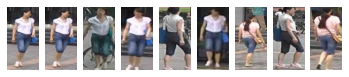

results for:
query=0272_c6_047404778.jpg  preds = ['0272_c6_081630355.jpg', '0272_c6_047404778.jpg', '0272_c6_025905383.jpg', '0272_c5_006749780.jpg', '0272_c1_002783252.jpg']


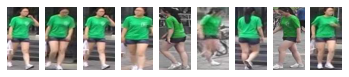

results for:
query=0272_c6_024966892.jpg  preds = ['0272_c6_024966892.jpg', '0272_c1_034523377.jpg', '0272_c6_041770347.jpg', '0272_c3_066574127.jpg', '0272_c6_041060853.jpg']


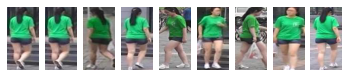

results for:
query=0703_c4_053847278.jpg  preds = ['0703_c4_053847278.jpg', '1232_c2_062274984.jpg', '0703_c1_001351987.jpg', '1232_c2_068261321.jpg', '0753_c3_057953322.jpg']


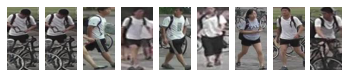

FINAL: Mean Average Precision Validation = 0.5041847946912865
last execution ID =  18:20:22


In [21]:
map, predictions = test_task_2(neural_net, val_loader_task2, 0, n_queries=100)
print(f'FINAL: Mean Average Precision Validation = {map}') 
print('last execution ID = ', time)

torch.save(neural_net.state_dict(), "./Bruna_eval.pkl")